#### imports

In [ ]:
import numpy as np 
import pandas as pd
import re
import string
from gensim.models import Word2Vec

import tensorflow.keras as tfk

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras import layers

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow import keras 
from keras.models import Sequential 
from keras import Input 
from keras.layers import Dense 
import tensorflow as tf

In [ ]:
# we are only submitting the notebook, so you will likley need your own kaggle API Token
# file (json) to be able to run these commands. read more about it here:
# https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Sets + Preprocessing 

Separate languages into numerical encoded classes

In [ ]:
lang_class = {'portuguese': 0, 'spanish': 1, 'english': 2, 
              0: 'portuguese', 1: 'spanish', 2: 'english'}
lang_class_other  = {'portuguese': 2, 'spanish': 1, 'english': 0, 
              2: 'portuguese', 1: 'spanish', 0: 'english'}

Hardcode variables; may change if needed

In [ ]:
EMBEDDINGS_SIZE = 100
SCALE_LINES = 151000
NGRAM = 3 

Util functions for tokenization

In [ ]:
def seperate_lines(content):
  """
  content: a list of chunks of text in the format [['text\nmoret text] , ...]
  
  return: a list of list of lines of text from the content 
            seperated by new line tokens in the format
            ['text', 'moret text' , ...]
  """
  strip_lines = []
  for poem in content:
      if len(poem.strip()) == 0:
          continue
      sent_data = [x for x in re.split(r'\n|\r|/|//|»|\r\n', poem)  if x] 
      #these were some of the new line tokens I identified
      for i in range(len(sent_data)):
          # remove any extraneous whitespace
          sent_data[i] = sent_data[i].strip()
      t = tuple(sent_data)
      strip_lines += list(t)
  return strip_lines


def tokenize_lines(lines):
  """
  lines: list of lines in a text. 
         pre split on end line tokens  in the format (not cleaned
         for excess punctuation)
         [['text', 'moret text'] , ...]

  return tokenized_lines: an list of sentences represented as a list
              of tokens with start and end tokens <s> and </s>
              in the format [[<s>, text, </s], [<s>, moret, text, </s>], ...]
        cleaned_lines : a list of lines of text with the same format as input
               but cleaned of extra punctuation
  """
  tokenized_lines = []
  cleaned_lines = []
  
  for line in lines:
      line_words = line.split()
      line_words_clean = []
      for lw in line_words: # ty geeks for geeks
        line_words_clean.append(lw.translate(str.maketrans('', '', string.punctuation)))
      start_tok = "<s>"
      end_tok = "</s>"
      sentence_clean = " ".join(line_words_clean)
      line_words_clean.insert(0, start_tok)
      line_words_clean.append(end_tok)
      tokenized_lines.append(line_words_clean)
      cleaned_lines.append(sentence_clean)

  return tokenized_lines, cleaned_lines


## Portuguese

Lots of poems in portuguese from the Kaggle set. This was a bit tough to parse at first as there were a lot of different line breaks, etc. that were not found in other texts.

https://www.kaggle.com/datasets/oliveirasp6/poems-in-portuguese 
15,543 texts by the most renowned Brazilian authors gathered from the website https://www.escritas.org/pt/poemas.

In [ ]:
! kaggle datasets download -d oliveirasp6/poems-in-portuguese
! unzip poems-in-portuguese.zip
! mv portuguese-poems.csv dataset-portuguese.csv

 73% 4.00M/5.50M [00:00<00:00, 6.25MB/s]
100% 5.50M/5.50M [00:00<00:00, 5.91MB/s]
Archive:  poems-in-portuguese.zip
  inflating: portuguese-poems.csv    


Read CSV and import dataset

In [ ]:
dataset_portuguese = pd.read_csv('dataset-portuguese.csv')
dataset_portuguese.head() # read for sanity

,Author,Title,Content,Views
0,Cecília Meireles,Retrato,"Eu não tinha este rosto de hoje,\r\nAssim calm...",1018431
1,Fernando Pessoa,"Para ser grande, sê inteiro: nada","Para ser grande, sê inteiro: nada\r\nTeu exage...",1979413
2,Marina Colasanti,"Eu sei, mas não devia",Eu sei que a gente se acostuma. Mas não devia....,301509
3,Carlos Drummond de Andrade,Quadrilha,João amava Teresa que amava Raimundo\r\nque am...,1421206
4,Eugénio de Andrade,É urgente o amor,É urgente o amor.\r\nÉ urgente um barco no mar...,621197


In [ ]:
#drop NA content, reindex if any was dropped
print(dataset_portuguese.count())
dataset_portuguese.dropna(subset=['Content'],inplace=True)
dataset_portuguese.reset_index(drop=True,inplace=True)
print(dataset_portuguese.count())
#there werent any, just checking :)

Author     15543
Title      15543
Content    15541
Views      15543
dtype: int64
Author     15541
Title      15541
Content    15541
Views      15541
dtype: int64


Get the actual text, we don't care about authors, title, views, etc.

In [ ]:
poems_portuguese = dataset_portuguese[['Content']]
poems_portuguese.head()

,Content
0,"Eu não tinha este rosto de hoje,\r\nAssim calm..."
1,"Para ser grande, sê inteiro: nada\r\nTeu exage..."
2,Eu sei que a gente se acostuma. Mas não devia....
3,João amava Teresa que amava Raimundo\r\nque am...
4,É urgente o amor.\r\nÉ urgente um barco no mar...


Insert the language flag as Portuguese

In [ ]:
poems_portuguese.insert(1, "Language", lang_class['portuguese'])
poems_portuguese.head()

,Content,Language
0,"Eu não tinha este rosto de hoje,\r\nAssim calm...",0
1,"Para ser grande, sê inteiro: nada\r\nTeu exage...",0
2,Eu sei que a gente se acostuma. Mas não devia....,0
3,João amava Teresa que amava Raimundo\r\nque am...,0
4,É urgente o amor.\r\nÉ urgente um barco no mar...,0


Get poem content in array

In [ ]:
content_portuguese = poems_portuguese['Content'].array
print(len(content_portuguese))

15541


Separate lines of poems

In [ ]:
lines_portuguese = seperate_lines(content_portuguese)
print(len(lines_portuguese))


317296


Tokenize

In [ ]:
tokenized_portuguese, cleaned_portuguese = tokenize_lines(lines_portuguese)
print(len(tokenized_portuguese))

317296


Put into a word2vec!

In [ ]:
word2vec_portuguese = Word2Vec(sentences=tokenized_portuguese, vector_size=EMBEDDINGS_SIZE, window=5, min_count=1, workers=4, sg=1)
word2vec_portuguese.save("word2vec_portuguese.model")
print(word2vec_portuguese.wv.vectors.shape)

(162761, 100)


##Spanish

There are a few less comments here as to not crowd the notebook, and there is less need as the steps are the exact same as Portuguese; we left comments where it may be confusing.

https://www.kaggle.com/datasets/andreamorgar/spanish-poetry-dataset Spanish poems gathered from www.poemas-del-alma.com each with the name of the poet, poem, and poem title. 

In [ ]:
! kaggle datasets download -d andreamorgar/spanish-poetry-dataset
! unzip spanish-poetry-dataset.zip
! mv poems.csv dataset-spanish.csv

 94% 2.00M/2.12M [00:00<00:00, 2.96MB/s]
100% 2.12M/2.12M [00:00<00:00, 2.71MB/s]
Archive:  spanish-poetry-dataset.zip
  inflating: poems.csv               


In [ ]:
dataset_spanish = pd.read_csv('dataset-spanish.csv')
dataset_spanish.head()

,author,content,title
0,Leopoldo Lugones,\n\nEn el parque confuso\nQue con lánguidas br...,LA MUERTE DE LA LUNA
1,Marilina Rébora,"\n\nPorque si tú no velas, vendré como ladrón;...",PORQUE SI TÚ NO VELAS
2,Antonio Colinas,"\n\nPequeña de mis sueños, por tu piel las pal...",POEMA DE LA BELLEZA CAUTIVA QUE PERDÍ
3,José María Hinojosa,\n\nLos dedos de la nieve\nrepiquetearon\nen e...,SENCILLEZ
4,Rubén Izaguirre Fiallos,"Naciste en Armenia,\npero te fuiste a vivir al...",Breve Carta a Consuelo Suncín


In [ ]:
#drop NA content, reindex if any was dropped
print(dataset_spanish.count())
dataset_spanish.dropna(subset=['content'],inplace=True)
dataset_spanish.reset_index(drop=True,inplace=True)
print(dataset_spanish.count())

author     5131
content    5131
title      5131
dtype: int64
author     5131
content    5131
title      5131
dtype: int64


In [ ]:
poems_spanish = dataset_spanish[['content']]
poems_spanish = poems_spanish.rename(columns={'content': 'Content'}) 
poems_spanish.head()

,Content
0,\n\nEn el parque confuso\nQue con lánguidas br...
1,"\n\nPorque si tú no velas, vendré como ladrón;..."
2,"\n\nPequeña de mis sueños, por tu piel las pal..."
3,\n\nLos dedos de la nieve\nrepiquetearon\nen e...
4,"Naciste en Armenia,\npero te fuiste a vivir al..."


In [ ]:
poems_spanish.insert(1, "Language", lang_class['spanish'])
poems_spanish.head()

,Content,Language
0,\n\nEn el parque confuso\nQue con lánguidas br...,1
1,"\n\nPorque si tú no velas, vendré como ladrón;...",1
2,"\n\nPequeña de mis sueños, por tu piel las pal...",1
3,\n\nLos dedos de la nieve\nrepiquetearon\nen e...,1
4,"Naciste en Armenia,\npero te fuiste a vivir al...",1


In [ ]:
content_spanish = poems_spanish['Content'].array
print(len(content_spanish))

5131


In [ ]:
# things to note: only saw spanish and \n seperated lines 
# am also actually seeing some english 
# Nnoticing some \x97 and » dont know what it is? line separaator?
lines_spanish = seperate_lines(content_spanish)
# lines_spanish
print(len(lines_spanish))

151125


In [ ]:
tokenized_spanish, cleaned_spanish = tokenize_lines(lines_spanish)
print(len(tokenized_spanish))

151125


In [ ]:
word2vec_spanish = Word2Vec(sentences=tokenized_spanish, vector_size=EMBEDDINGS_SIZE, window=5, min_count=1, workers=4, sg=1)
word2vec_spanish.save("word2vec_spanish.model")
print(word2vec_spanish.wv.vectors.shape)

(64915, 100)


## English

Same as above, one more time with English!

https://www.kaggle.com/datasets/watrgoat/lots-of-poems the poems are from the poetry foundation website. 

In [ ]:
! kaggle datasets download -d watrgoat/lots-of-poems
! unzip lots-of-poems.zip
! mv mostly_english_poems.csv dataset-english.csv

 99% 60.0M/60.4M [00:05<00:00, 16.8MB/s]
100% 60.4M/60.4M [00:05<00:00, 11.4MB/s]
Archive:  lots-of-poems.zip
  inflating: mostly_english_poems.csv  
  inflating: mostly_english_poems.pickle  
  inflating: ready_poems.csv         
  inflating: ready_poems.pickle      


In [ ]:
dataset_english = pd.read_csv('dataset-english.csv')
dataset_english.head()

,Unnamed: 0,title,author,content,tags
0,0,Do not go gentle into that good night,Dylan Thomas,"Do not go gentle into that good night,\nOld ag...",[]
1,1,How Do I Love Thee? (Sonnet 43),Elizabeth Barrett Browning,How do I love thee? Let me count the ways.\nI ...,[]
2,2,Shall I compare thee to a summer’s day? (Sonne...,William Shakespeare,Shall I compare thee to a summer’s day?\nThou ...,[]
3,3,If—,Rudyard Kipling,If you can keep your head when all about you\n...,[]
4,4,Nothing Gold Can Stay,Robert Frost,"Nature’s first green is gold,\nHer hardest hue...",[]


In [ ]:
#drop NA content, reindex if any was dropped
print(dataset_english.count())
dataset_english.dropna(subset=['content'],inplace=True)
dataset_english.reset_index(drop=True,inplace=True)
print(dataset_english.count())

Unnamed: 0    26817
title         26817
author        26796
content       26817
tags          26817
dtype: int64
Unnamed: 0    26817
title         26817
author        26796
content       26817
tags          26817
dtype: int64


In [ ]:
poems_english = dataset_english[['content']]
poems_english = poems_english.rename(columns={'content': 'Content'}) 
poems_english.head()

,Content
0,"Do not go gentle into that good night,\nOld ag..."
1,How do I love thee? Let me count the ways.\nI ...
2,Shall I compare thee to a summer’s day?\nThou ...
3,If you can keep your head when all about you\n...
4,"Nature’s first green is gold,\nHer hardest hue..."


In [ ]:
poems_english.insert(1, "Language", lang_class['english'])
poems_english.head()

,Content,Language
0,"Do not go gentle into that good night,\nOld ag...",2
1,How do I love thee? Let me count the ways.\nI ...,2
2,Shall I compare thee to a summer’s day?\nThou ...,2
3,If you can keep your head when all about you\n...,2
4,"Nature’s first green is gold,\nHer hardest hue...",2


In [ ]:
content_english = poems_english['Content'].array
# print(len(content_english))
# content_english

In [ ]:
# things to note:
lines_english = seperate_lines(content_english)
# lines_english
print(len(lines_english))

901433


In [ ]:
tokenized_english, cleaned_english = tokenize_lines(lines_english)
# tokenized_english
print(len(tokenized_english))

901433


In [ ]:
word2vec_english = Word2Vec(sentences=tokenized_english, vector_size=EMBEDDINGS_SIZE, window=5, min_count=1, workers=4, sg=1)
word2vec_english.save("word2vec_english.model")
print(word2vec_english.wv.vectors.shape)

(226509, 100)


# Naive Bayes

Scale our data so that we have equal amounts of all data

In [ ]:
train_NB_portuguese = cleaned_portuguese[0:round(SCALE_LINES/2)]
train_NB_spanish = cleaned_spanish[0:round(SCALE_LINES/2)]
train_NB_english = cleaned_english[0:round(SCALE_LINES/2)]
train_NB_corpus = train_NB_portuguese + train_NB_spanish + train_NB_english
print(len(train_NB_corpus))

train_NB_gold = [lang_class['portuguese'] for i in range(round(SCALE_LINES/2))]
train_NB_gold += [lang_class['spanish'] for i in range(round(SCALE_LINES/2))]
train_NB_gold += [lang_class['english'] for i in range(round(SCALE_LINES/2))]
print(len(train_NB_gold))

test_NB_portuguese = cleaned_portuguese[-(round(SCALE_LINES/2)):]
test_NB_spanish = cleaned_spanish[-(round(SCALE_LINES/2)):]
test_NB_english = cleaned_english[-(round(SCALE_LINES/2)):]
test_NB_corpus = test_NB_portuguese + test_NB_spanish + test_NB_english
print(len(test_NB_corpus))
test_NB_gold = train_NB_gold
print(len(test_NB_gold))

226500
226500
226500
226500


Vectorize our NB data

In [ ]:
NB_vectorizer = TfidfVectorizer()
train_NB_X = NB_vectorizer.fit_transform(train_NB_corpus)
print(train_NB_X.shape)

(226500, 103363)


In [ ]:
# print(NB_vectorizer.get_feature_names_out())
# print(NB_vectorizer.get_feature_names_out()[6000:6900])
# i can see the portuguese c and also different spanish accents in the words
# why are there random unicode characters and chinese characters?
# unsure if need to chaneg encoding to ISO-8859-1 or if utf 8 is fine
# both look fine in terms of output here

Fit NB Model

In [ ]:
NB_model = MultinomialNB()
NB_model.fit(train_NB_X, train_NB_gold)

MultinomialNB()

Predict!

In [ ]:
train_NB_pred = NB_model.predict(train_NB_X)

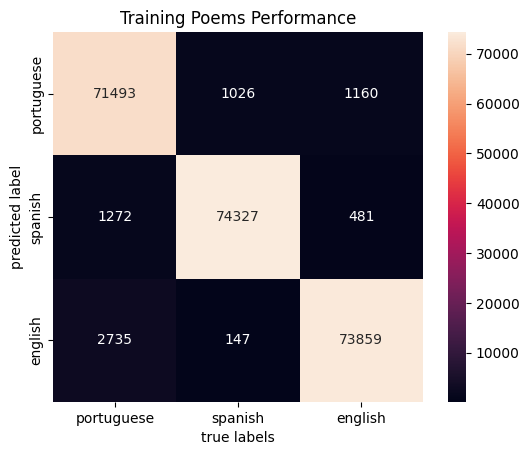

The accuracy is 0.9698852097130243


In [ ]:
mat = confusion_matrix(train_NB_gold, train_NB_pred)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=[ lang_class[0], lang_class[1], lang_class[2]],yticklabels=[lang_class[0], lang_class[1], lang_class[2]])
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.title("Training Poems Performance")
plt.show()
print("The accuracy is {}".format(accuracy_score(train_NB_gold, train_NB_pred)))

In [ ]:
def test_model_and_graph(model, classes, sentences, gold, graph_title):
  """
  model: the NB model to test on 
  lang_class: a dictonary of the string representations of the classes to their numerical class representation (and vice versa)
  sentences: a list of strings to classify 
  gold: a list of numercal class value representatiosn that correspond to the sentences
  graph_title : string of what to name the graph
  """
  X = NB_vectorizer.transform(sentences)
  pred = model.predict(X)
  print("The accuracy is {}".format(accuracy_score(gold, pred)))
  mat = confusion_matrix(gold, pred)
  sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=[classes[0], classes[1], classes[2]],yticklabels=[classes[0], classes[1], classes[2]])
  plt.title(graph_title)
  plt.xlabel("true labels")
  plt.ylabel("predicted label")
  plt.show()

The accuracy is 0.9451169977924945


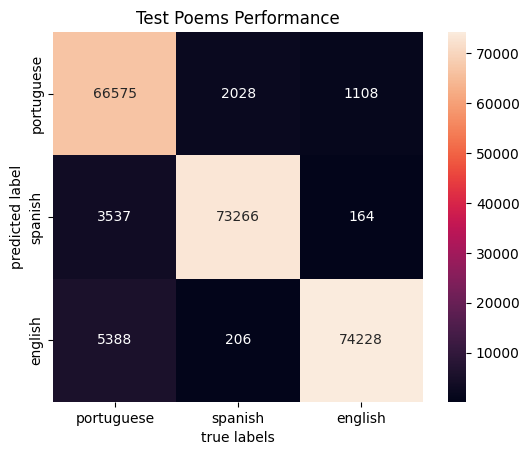

In [ ]:
test_model_and_graph(NB_model, lang_class, test_NB_corpus, test_NB_gold, "Test Poems Performance")

## manual testing

In [ ]:
def NBmodel_smol_tests(model, classes, sentences):
  X = NB_vectorizer.transform(sentences)
  pred = model.predict(X)
  [print(sentences[i], "is", classes[pred[i]]) for i in range(len(sentences))]

NBmodel_smol_tests(NB_model, lang_class, ["Nicole", "Sierra", "Buckley", "Rodriguez"])
NBmodel_smol_tests(NB_model, lang_class, ["hello", "hola", "olá"])
NBmodel_smol_tests(NB_model, lang_class, ["good morning", "buenos días", "bom dia"])

Nicole is english
Sierra is spanish
Buckley is portuguese
Rodriguez is english
hello is english
hola is portuguese
olá is portuguese
good morning is english
buenos días is spanish
bom dia is portuguese


## Stop words testing

Out of curiosity, see how naive bayes would allocate words that are very common to the respective languages 

In [ ]:
! kaggle datasets download -d heeraldedhia/stop-words-in-28-languages
! unzip stop-words-in-28-languages.zip 

  0% 0.00/34.4k [00:00<?, ?B/s]
100% 34.4k/34.4k [00:00<00:00, 1.76MB/s]
Archive:  stop-words-in-28-languages.zip
  inflating: arabic.txt              
  inflating: bulgarian.txt           
  inflating: catalan.txt             
  inflating: czech.txt               
  inflating: danish.txt              
  inflating: dutch.txt               
  inflating: english.txt             
  inflating: finnish.txt             
  inflating: french.txt              
  inflating: german.txt              
  inflating: gujarati.txt            
  inflating: hebrew.txt              
  inflating: hindi.txt               
  inflating: hungarian.txt           
  inflating: indonesian.txt          
  inflating: italian.txt             
  inflating: malaysian.txt           
  inflating: norwegian.txt           
  inflating: polish.txt              
  inflating: portuguese.txt          
  inflating: romanian.txt            
  inflating: russian.txt             
  inflating: slovak.txt              
  inflating:

The accuracy is 0.788961038961039


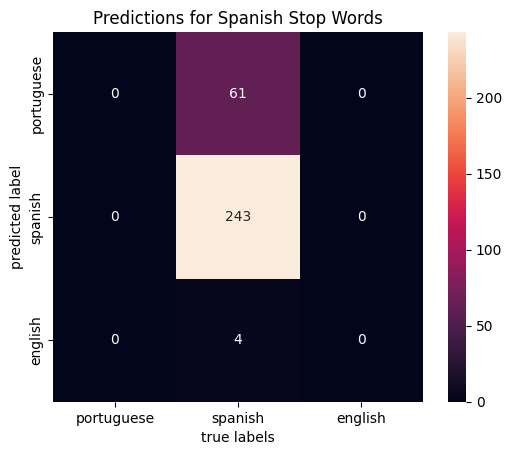

In [ ]:
f = open("spanish.txt")
stop_words_spanish = f.readlines()
f.close()
stop_words_spanish = [x.strip() for x in stop_words_spanish]

test_model_and_graph(NB_model, lang_class, stop_words_spanish, [lang_class['spanish'] for x in range(len(stop_words_spanish))], 
                  "Predictions for Spanish Stop Words")

The accuracy is 0.9211822660098522


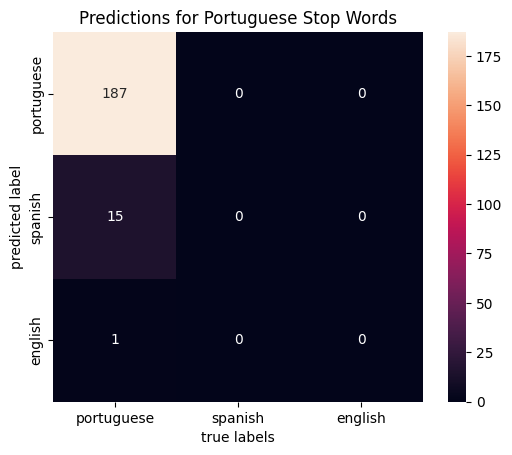

In [ ]:
f = open("portuguese.txt")
stop_words_portuguese = f.readlines()
f.close()
stop_words_portuguese = [x.strip() for x in stop_words_portuguese]

test_model_and_graph(NB_model, lang_class, stop_words_portuguese, [lang_class['portuguese'] for x in range(len(stop_words_portuguese))], 
                  "Predictions for Portuguese Stop Words")

The accuracy is 0.7388289676425269


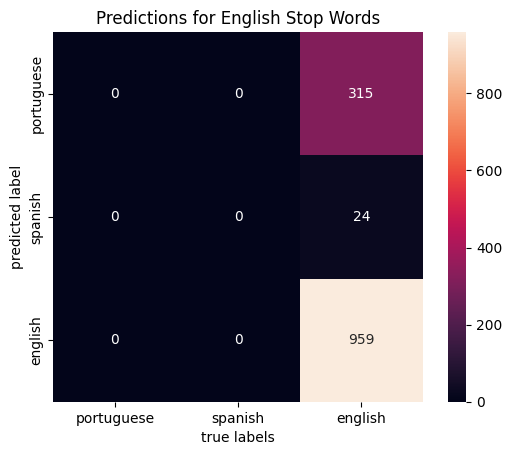

In [ ]:
f = open("english.txt")
stop_words_english = f.readlines()
f.close()
stop_words_english = [x.strip() for x in stop_words_english]

test_model_and_graph(NB_model, lang_class, stop_words_english, [lang_class['english'] for x in range(len(stop_words_english))], 
                  "Predictions for English Stop Words")

In [ ]:
sp_pt_overlap = set(stop_words_spanish).intersection(set(stop_words_portuguese))
sp_en_overlap = set(stop_words_spanish).intersection(set(stop_words_english))
en_pt_overlap = set(stop_words_english).intersection(set(stop_words_portuguese))
en_sp_pt_overlap = sp_pt_overlap.intersection(en_pt_overlap)

print("The actual overlap of Spanish and Portuguese words", len(sp_pt_overlap))
print("The actual overlap of Spanish and English words", len(sp_en_overlap))
print("The actual overlap of English and Portuguese words", len(en_pt_overlap))
print("The actual overlap of English, Spanish, and Portuguese words", len(en_sp_pt_overlap))

The actual overlap of Spanish and Portuguese words 28
The actual overlap of Spanish and English words 19
The actual overlap of English and Portuguese words 16
The actual overlap of English, Spanish, and Portuguese words 9


Most likley the reason that the model determines most of the time in favor of Portuguese is because the model does not "know" the words that it's being show and when it hasnt seen a word it is assigned the lowest probability 0 which is where poruguese was assigned its discreted value. 

We can investigate this later by changing the language classes from lang_class to lang_class_other and running the same test and seeing if the lanaguage more accuratley (or rather more often) predicts (in the case of lang_class_other) English. 

I did this intentionally because I noticed that a lot of times if GoogleTranslate isnt certain what language you're talking in, it defaults to English. While neither of these behaviours is ideal, the former reinforces that English is the default language. 

In [ ]:
train_NB_gold_other = [lang_class_other['portuguese'] for i in range(round(SCALE_LINES/2))]
train_NB_gold_other += [lang_class_other['spanish'] for i in range(round(SCALE_LINES/2))]
train_NB_gold_other += [lang_class_other['english'] for i in range(round(SCALE_LINES/2))]
print(len(train_NB_gold_other))

226500


In [ ]:
NB_model_other = MultinomialNB()
NB_model_other.fit(train_NB_X, train_NB_gold_other)

MultinomialNB()

The accuracy is 0.9721324503311258


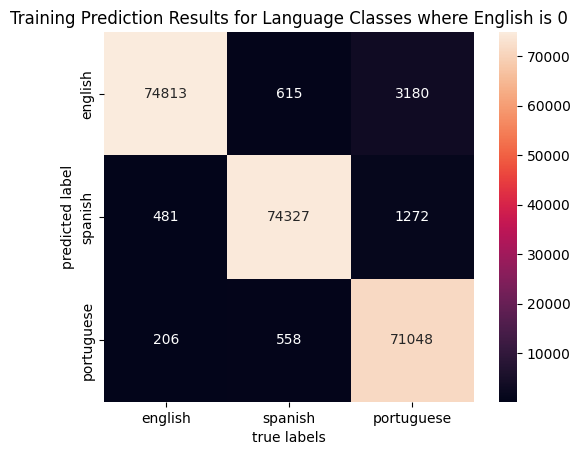

In [ ]:
train_NB_pred_other = NB_model_other.predict(train_NB_X)
print("The accuracy is {}".format(accuracy_score(train_NB_gold_other, train_NB_pred_other)))
mat = confusion_matrix(train_NB_gold_other, train_NB_pred_other)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=[lang_class_other[0], lang_class_other[1], lang_class_other[2]],yticklabels=[lang_class_other[0], lang_class_other[1], lang_class_other[2]])
plt.title("Training Prediction Results for Language Classes where English is 0")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

Interestingly accuracy is now higher even thought all that was changed was the classes. From 96.9% to 97.2%. Its not that BIG of a difference, but a difference nonetheless

In [ ]:
NBmodel_smol_tests(NB_model_other, lang_class_other, ["Nicole", "Buckley", "Sierra", "Rodriguez"])
NBmodel_smol_tests(NB_model_other, lang_class_other, ["hello", "hola", "olá"])
NBmodel_smol_tests(NB_model_other, lang_class_other,  ["good morning", "buenos días", "bom dia"])

Nicole is english
Buckley is english
Sierra is spanish
Rodriguez is english
hello is english
hola is english
olá is portuguese
good morning is english
buenos días is spanish
bom dia is portuguese


The accuracy is 0.9391371340523883


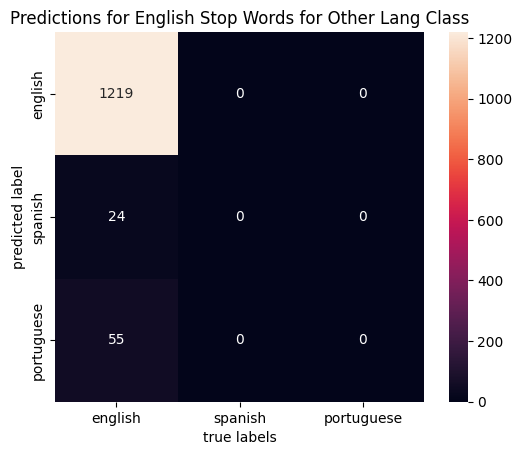

In [ ]:
test_model_and_graph(NB_model_other, lang_class_other, stop_words_english, [lang_class_other['english'] for x in range(len(stop_words_english))], 
                  "Predictions for English Stop Words for Other Lang Class")

Wow and thats what you call underresourced languages haha.... 

The accuracy is 0.788961038961039


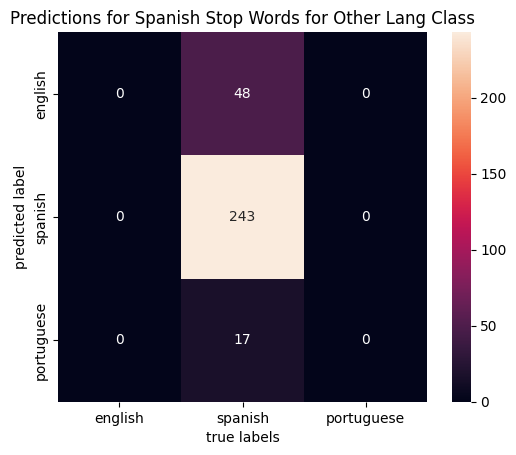

In [ ]:
test_model_and_graph(NB_model_other, lang_class_other, stop_words_spanish, [lang_class_other['spanish'] for x in range(len(stop_words_spanish))], 
                  "Predictions for Spanish Stop Words for Other Lang Class")

The accuracy is 0.8078817733990148


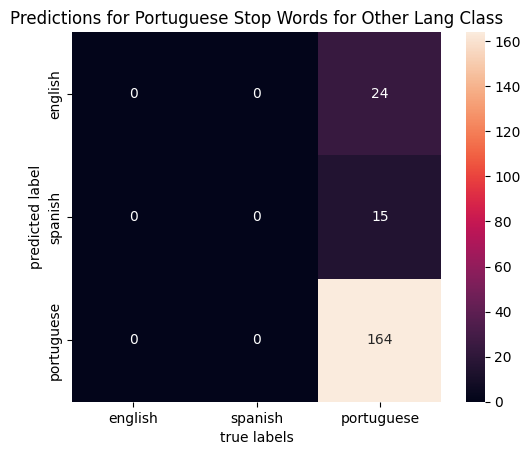

In [ ]:
test_model_and_graph(NB_model_other, lang_class_other, stop_words_portuguese, [lang_class_other['portuguese'] for x in range(len(stop_words_portuguese))], 
                  "Predictions for Portuguese Stop Words for Other Lang Class")

# FFNN

In [ ]:
train_FN_portuguese = tokenized_portuguese[0:round(SCALE_LINES/2)]
train_FN_spanish = tokenized_spanish[0:round(SCALE_LINES/2)]
train_FN_english = tokenized_english[0:round(SCALE_LINES/2)]
train_FN_corpus = train_FN_portuguese + train_FN_spanish + train_FN_english
print(len(train_FN_corpus))
print(len(train_FN_portuguese))
print(len(train_FN_spanish))
print(len(train_FN_english))

In [ ]:
labels = []

pt1 = 75500
pt2 = 75500*2
pt3 = 75500*3

for i in range(pt3):
  if i < pt1:
    labels.append(np.array([1,0,0]))
  elif i < pt2:
    labels.append(np.array([0,1,0]))
  elif i < pt3:
    labels.append(np.array([0,0,1]))

labels = np.

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for doc, i in zip(train_FN_corpus, labels)]

In [ ]:
from gensim.models.doc2vec import Doc2Vec
doc2vec_ffnn = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)
doc2vec_ffnn.save("doc2vec_ffnn.model")

In [ ]:
vec=np.array([doc2vec_ffnn.infer_vector(item) for item in train_FN_corpus])

In [ ]:
vec.shape

In [ ]:
nested_labels = []
pt2 = 75500*2
pt3 = 75500*3
for i in range(226500):
  if i < 75500:
    nested_labels.append(np.array([1, 0, 0]))
  elif i < pt2:
    nested_labels.append(np.array([0, 1, 0]))
  elif i < pt3:
    nested_labels.append(np.array([0, 0, 1]))
    
labels = np.array(labels)

nested_labels = np.array(nested_labels)

In [ ]:
# The code here is a combination of the compile and fit parameters we came up 
# with ourselves, along with code adapted from the following medium article:
# (We just changed the input layer numbers and the output so it could classify)
# https://medium.com/@canerkilinc/hands-on-tensorflow-2-0-multi-label-classifications-with-mlp-88fc97d6a7e6
ffn_model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(200, activation='relu'), 
                                    tf.keras.layers.Dense(64, activation='relu'), 
                                    tf.keras.layers.Dense(32, activation='relu'), 
                                    tf.keras.layers.Dense(3, activation='softmax')])

# compile model, 
ffn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss=tf.keras.losses.CategoricalCrossentropy(),
                 metrics=['accuracy'])

ffn_history = ffn_model.fit(vec, nested_labels, batch_size=128, epochs=100, verbose=1)

In [ ]:
import plotly.express as px

px.line(ffn_history.history['accuracy'], labels= {'value' : 'accuracy',
                                                  'index' : 'epoch'},
        title = 'Accuracy at 128 batch size')

In [ ]:
px.line(ffn_history.history['loss'], labels= {'value' : 'loss',
                                                  'index' : 'epoch'},
        title = 'Loss at 128 batch size')

<h1> RNN </h1>

# RNN

Some references: 
https://www.tensorflow.org/text/tutorials/text_classification_rnn

https://www.tensorflow.org/text/tutorials/text_generation

https://www.tensorflow.org/guide/keras/rnn

https://www.google.com/search?client=safari&rls=en&q=how+to+make+a+tfds+dataset&ie=UTF-8&oe=UTF-8


In [ ]:
import tensorflow as tf
import unicodedata
import string
import keras

from keras.callbacks import Callback
! pip install scikit-plot
from scikitplot.metrics import plot_confusion_matrix, plot_roc
import os


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

EPOCHS = 5

## training the encoder and decoder

In [ ]:
RNN_corpus = " ".join(cleaned_portuguese[0:round(SCALE_LINES/2)]) + " ".join(cleaned_spanish[0:round(SCALE_LINES/2)]) + " ".join(cleaned_english[0:round(SCALE_LINES/2)])
RNN_vocab = list(set(RNN_corpus))
print(len(RNN_vocab))
# print(RNN_corpus[0:250])
print(RNN_vocab[0:100])
# print(RNN_vocab[100:200])
# print(RNN_vocab[200:300])
# print(RNN_vocab[300:342])

In [ ]:
char_to_enc = tf.keras.layers.StringLookup(
    vocabulary=RNN_vocab)

In [ ]:
enc_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_enc.get_vocabulary(), invert=True)

In [ ]:
def encs_to_utf_text(encs):
  """
  encs: list of encodings to turn into full text
  """
  tensor =  tf.strings.reduce_join(enc_to_char(encs), axis=-1)
  sentences = tensor.numpy()
  sentences = [s.decode("UTF-8") for s in sentences]
  return sentences

## data set up

In [ ]:
train_RNN_sentences = cleaned_portuguese[0:round(SCALE_LINES/2)] + cleaned_spanish[0:round(SCALE_LINES/2)] + cleaned_english[0:round(SCALE_LINES/2)]
test_RNN_sentences = cleaned_english[-(round(SCALE_LINES/2)):] + cleaned_spanish[-(round(SCALE_LINES/2)):] + cleaned_portuguese[-(round(SCALE_LINES/2)):]

onehot_lang = {'portuguese': [1, 0, 0], 'spanish': [0, 1, 0], "english": [0, 0, 1]}

train_RNN_labelss = [onehot_lang['portuguese']] * round(SCALE_LINES/2) + [onehot_lang['spanish']] * round(SCALE_LINES/2)  + [onehot_lang['english']] * round(SCALE_LINES/2)
test_RNN_labelss = [onehot_lang['english']] * round(SCALE_LINES/2) + [onehot_lang['spanish']] * round(SCALE_LINES/2)  + [onehot_lang['portuguese']] * round(SCALE_LINES/2)

train_RNN_words_pt = [] 
train_RNN_words_sp = []
train_RNN_words_en = []

#notes that the words in test_sentences and test_words are NOT the same
test_RNN_words_pt = [] 
test_RNN_words_sp = [] 
test_RNN_words_en =  [] 

for i in range(round(SCALE_LINES/2)):
  train_RNN_words_pt += cleaned_portuguese[i].split(" ")
  train_RNN_words_sp += cleaned_spanish[i].split(" ")
  train_RNN_words_en += cleaned_english[i].split(" ")
  test_RNN_words_pt += cleaned_portuguese[i+round(SCALE_LINES/2)].split(" ")
  test_RNN_words_sp += cleaned_spanish[i+round(SCALE_LINES/2)].split(" ")
  test_RNN_words_en += cleaned_english[i+round(SCALE_LINES/2)].split(" ")

train_RNN_words = train_RNN_words_pt + train_RNN_words_sp + train_RNN_words_en
test_RNN_words = test_RNN_words_pt + test_RNN_words_sp + test_RNN_words_en

print("words in each language")
print("pt", len(test_RNN_words_pt))
print("sp", len(test_RNN_words_sp))
print("en", len(test_RNN_words_en))
print("total: " + str(len(test_RNN_words_pt) + len(test_RNN_words_sp) + len(test_RNN_words_en)))

train_RNN_labelsw = [onehot_lang['portuguese']] * len(train_RNN_words_pt) + [onehot_lang['spanish']] * len(train_RNN_words_sp)  + [onehot_lang['english']] * len(train_RNN_words_en)
test_RNN_labelsw = [onehot_lang['portuguese']] * len(test_RNN_words_pt) + [onehot_lang['spanish']] * len(test_RNN_words_sp)  + [onehot_lang['english']] * len(test_RNN_words_en)


#stplit all the sentences on each character and make into tensors
train_RNN_sentences_dec = tf.strings.unicode_split(
    train_RNN_sentences,
    input_encoding='UTF-8',
    name="training input"
)

train_RNN_words_dec = tf.strings.unicode_split(
    train_RNN_words,
    input_encoding='UTF-8',
    name="training input"
)

test_RNN_sentences_dec = tf.strings.unicode_split(
    test_RNN_sentences,
    input_encoding='UTF-8',
    name="training input"
)

test_RNN_words_dec = tf.strings.unicode_split(
    test_RNN_words,
    input_encoding='UTF-8',
    name="training input"
)

RNN_corpus_unicode = tf.strings.unicode_split(
    RNN_corpus,
    input_encoding='UTF-8',
    name="training corpus"
)

#encode all of the training/testing data 
train_RNN_sentences = char_to_enc(train_RNN_sentences_dec)
train_RNN_words = char_to_enc(train_RNN_words_dec)
test_RNN_sentences = char_to_enc(test_RNN_sentences_dec)
test_RNN_words = char_to_enc(test_RNN_words_dec)

In [ ]:
# test the enc and decoder 

print("decoded sentences")
print(train_RNN_sentences_dec[0:3])
enc_test = char_to_enc(train_RNN_sentences_dec[0:3])

print("encoded sentences")
print(enc_test)
dec_test = enc_to_char(enc_test)

print("decoded sentences")
print(dec_test)

print("completley decoded sentences")
print(encs_to_utf_text(enc_test))

In [ ]:
a = tf.data.Dataset.from_tensor_slices(train_RNN_labelss)
b = tf.data.Dataset.from_tensor_slices(train_RNN_sentences)
train_RNN_datasets =  tf.data.Dataset.zip((b, a))

for example, label in train_RNN_datasets.take(2):
  print(example)
  print(label)

a = tf.data.Dataset.from_tensor_slices(test_RNN_labelss)
b = tf.data.Dataset.from_tensor_slices(test_RNN_sentences)
test_RNN_datasets =  tf.data.Dataset.zip((b, a))

for example, label in test_RNN_datasets.take(2):
  print(example)
  print(label)

a = tf.data.Dataset.from_tensor_slices(train_RNN_labelsw)
b = tf.data.Dataset.from_tensor_slices(train_RNN_words)
train_RNN_datasetw =  tf.data.Dataset.zip((b, a))

a = tf.data.Dataset.from_tensor_slices(test_RNN_labelsw)
b = tf.data.Dataset.from_tensor_slices(test_RNN_words)
test_RNN_datasetw =  tf.data.Dataset.zip((b, a))




In [ ]:
#batch them
train_RNN_datasets = train_RNN_datasets.shuffle(4000)

for sample, label in test_RNN_datasets.take(1):
  print(sample)
  print(encs_to_utf_text([sample]))
  print(label)

train_RNN_datasets = train_RNN_datasets.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_RNN_datasets = test_RNN_datasets.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_RNN_datasetw = train_RNN_datasets.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_RNN_datasetw = test_RNN_datasets.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## models set up

In [ ]:
#@title Simple RNN Model
RNN_model_simple = tf.keras.Sequential([
    # char_to_enc, # for some reaon when i try to add the encoder to the model, it doesnt like it for the sumamry
    tf.keras.layers.Embedding(
        input_dim=len(char_to_enc.get_vocabulary()),
        output_dim=BATCH_SIZE),
    tf.keras.layers.SimpleRNN(BATCH_SIZE),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'), 
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(3, activation='softmax')]) #have 3 outputs that are the probability matrix over the 3 langauge classes

RNN_model_simple.summary()

In [ ]:
#@title Bidirectional RNN Model
RNN_model_bi = tf.keras.Sequential([
    # char_to_enc, # for some reaon when i try to add the encoder to the model, it doesnt like it for the sumamry
    tf.keras.layers.Embedding(
        input_dim=len(char_to_enc.get_vocabulary()),
        output_dim=BATCH_SIZE),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')]) #have 3 outputs that are the probability matrix over the 3 langauge classes

RNN_model_simple.summary()

## train simple rnn

In [ ]:
RNN_model_simple.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy',
                       tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision(),])

In [ ]:
print(EPOCHS)

In [ ]:
RNN_history_simples = RNN_model_simple.fit(train_RNN_datasets, epochs=EPOCHS,
                    validation_data=test_RNN_datasets,
                    validation_steps=30,)

In [ ]:
plt.plot(RNN_history_simples.history['accuracy'])
plt.plot(RNN_history_simples.history['recall'])
plt.plot(RNN_history_simples.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Recall', 'Test'], loc='upper left')
plt.show()

### test some examples

In [ ]:
def output_to_lang(prob_matrix):
  """
  prob_matrix: a matrix with liklihood extimates for each language sape = (1, 3)

  returns string of the class representaaion of the highest probbiality index
  """
  p = list(prob_matrix)
  m = max(p)
  index = p.index(m)
  return "(" + str(m) + ") " + lang_class[index]

def RNNmodel_smol_tests(model, sentences):
  s = tf.strings.unicode_split(
    sentences,
    input_encoding='UTF-8')
  X = char_to_enc(s)
  pred = model.predict(X)
  [print(sentences[i], "is", output_to_lang(pred[i])) for i in range(len(sentences))]

RNNmodel_smol_tests(RNN_model_simple, ["Nicole", "Sierra", "Buckley", "Rodriguez"])
RNNmodel_smol_tests(RNN_model_simple, ["hello", "hola", "olá"])
RNNmodel_smol_tests(RNN_model_simple, ["good morning", "buenos días", "bom dia"])

RNNmodel_smol_tests(RNN_model_simple, ["Su novio está cumpliendo una larga condena.", 
                                       "Si me ayudas con el almuerzo, te haré un rico postre.", 
                                       "Si me ganara la lotería, me compraría una casa en Mallorca. ", 
                                       "Por favor, me avise quando devo descer", 
                                       "Eu gosto muito de viajar para lugares diferentes e experimentar comidas novas.", 
                                       "Ontem assisti a um filme muito emocionante que me fez chorar no final.", 
                                       "I really enjoy traveling to different places and trying new foods.", 
                                       "Today is a very hot day, so I'm going to the beach to enjoy the sun.",
                                       "Yesterday I watched a very emotional movie that made me cry at the end."])


## train bidirectional rnn

In [ ]:
RNN_model_bi.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy',
                       tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision(),])

In [ ]:
RNN_history_bis = RNN_model_bi.fit(train_RNN_datasets, epochs=EPOCHS,
                    validation_data=test_RNN_datasets,
                    validation_steps=30,)

In [ ]:
plt.plot(RNN_history_bis.history['accuracy'])
plt.plot(RNN_history_bis.history['recall'])
plt.plot(RNN_history_bis.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Recall', 'Test'], loc='upper left')
plt.show()

### test some examples

In [ ]:
RNNmodel_smol_tests(RNN_model_bi, ["Nicole", "Sierra", "Buckley", "Rodriguez"])
RNNmodel_smol_tests(RNN_model_bi, ["hello", "hola", "olá"])
RNNmodel_smol_tests(RNN_model_bi, ["good morning", "buenos días", "bom dia"])

RNNmodel_smol_tests(RNN_model_bi, ["Su novio está cumpliendo una larga condena.", 
                                       "Si me ayudas con el almuerzo, te haré un rico postre.", 
                                       "Si me ganara la lotería, me compraría una casa en Mallorca. ", 
                                       "Por favor, me avise quando devo descer", 
                                       "Eu gosto muito de viajar para lugares diferentes e experimentar comidas novas.", 
                                       "Ontem assisti a um filme muito emocionante que me fez chorar no final.", 
                                       "I really enjoy traveling to different places and trying new foods.", 
                                       "Today is a very hot day, so I'm going to the beach to enjoy the sun.",
                                       "Yesterday I watched a very emotional movie that made me cry at the end."])
